# CNN intro

X_train.shape=(50000, 32, 32, 3), X_test.shape=(10000, 32, 32, 3)
y_train.shape=(50000,), y_test.shape=(10000,)


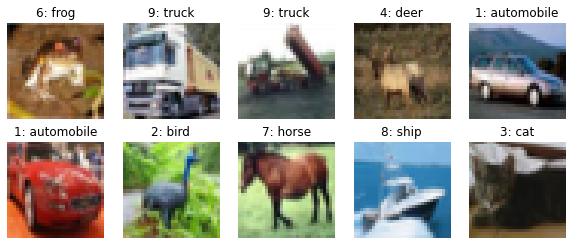

In [2]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from tensorflow.keras.datasets.cifar10 import load_data

(X_train, y_train), (X_test, y_test) = load_data()
print(f"{X_train.shape=}, {X_test.shape=}")
y_train, y_test = y_train.ravel(), y_test.ravel()
print(f"{y_train.shape=}, {y_test.shape=}")

labels = ["airplane",
          "automobile",
          "bird",
          "cat",
          "deer",
          "dog",
          "frog",
          "horse",
          "ship",
          "truck"]

fig, axes = plt.subplots(2, 5, figsize=(10, 4))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(X_train[i])
    ax.set_title(f"{y_train[i]}: {labels[y_train[i]]}")
    ax.axis("off")


In [3]:
scaled_X_train = X_train.astype("float32")/255
scaled_X_test = X_test.astype("float32")/255

# CNN model

In [4]:
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, Conv2D, Dropout, MaxPooling2D,Flatten
from tensorflow.keras.optimizers import Adam 

def CNN_model(learning_rate=0.001, drop_rate = .5, kernels = [32,64]): 
    adam = Adam(learning_rate= learning_rate) 

    model = Sequential(name = "CNN_model")

    # the convolutional layers 
    for number_kernel in kernels : 
        conv_layer = Conv2D(number_kernel, kernel_size = (3,3), activation = "relu", kernel_initializer = "he_normal", input_shape = X_train.shape[1:])
        model.add(conv_layer)
        model.add(MaxPooling2D(pool_size= (2,2), strides = 2))

    # MLP layers 
    model.add(Flatten()) 
    model.add(Dropout(drop_rate)) 
    model.add(Dense(256, activation = "relu", kernel_initializer = "he_normal")) 
    model.add(Dense(10))

    model.compile(loss="sparse_categorical_crossentropy",optimizer=adam, metrics=["accuracy"]) 

    return model 

model = CNN_model()
model.summary()


2022-05-03 19:43:26.092597: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "CNN_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 2304)              0         
                                                                 
 dropout (Dropout)           (None, 2304)              0 

In [5]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopper = EarlyStopping(monitor = "val_loss", mode = "min", patience = 5)

model.fit(
    scaled_X_train, 
    y_train, 
    epochs = 100, 
    callbacks = [early_stopper],
    validation_split = 1/5
)

Epoch 1/100
1250/1250 [==============================] - 99s 77ms/step - loss: 9.6343 - accuracy: 0.1036 - val_loss: 9.7201 - val_accuracy: 0.0952
Epoch 2/100
1250/1250 [==============================] - 67s 54ms/step - loss: 9.6556 - accuracy: 0.1029 - val_loss: 9.7201 - val_accuracy: 0.0952
Epoch 3/100
1250/1250 [==============================] - 72s 57ms/step - loss: 10.2561 - accuracy: 0.1022 - val_loss: 12.4183 - val_accuracy: 0.1022
Epoch 4/100
1250/1250 [==============================] - 73s 58ms/step - loss: 12.3720 - accuracy: 0.0994 - val_loss: 12.4183 - val_accuracy: 0.1022
Epoch 5/100
1250/1250 [==============================] - 102s 81ms/step - loss: 12.3720 - accuracy: 0.0994 - val_loss: 12.4183 - val_accuracy: 0.1022
Epoch 6/100
1250/1250 [==============================] - 80s 64ms/step - loss: 12.3720 - accuracy: 0.0994 - val_loss: 12.4183 - val_accuracy: 0.1022


In [11]:
def plot_metrics(metrics):
    _, ax = plt.subplots(1,2, figsize = (12,4))
    metrics[["loss", "val_loss"]].plot(ax = ax[0], grid = True)
    metrics[["accuracy", "val_accuracy"]].plot(ax = ax[1], grid = True)

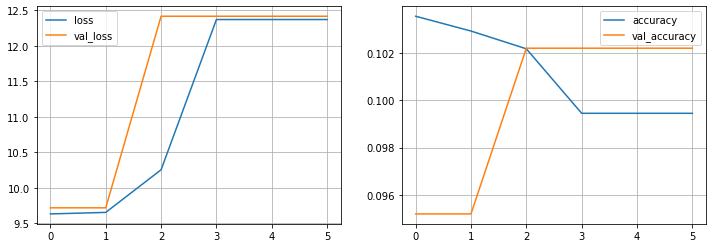

In [12]:
metrics = pd.DataFrame(model.history.history)
plot_metrics(metrics)

## Hyperparmeter tuning 

In [15]:
def evaluate_model(**kwargs):
    model = CNN_model(**kwargs)
    model.fit(
        scaled_X_train,
        y_train,
        validation_split = 1/5,
        epochs = 6,
    )

    metrics = pd.DataFrame(model.history.history)
    val_acc = metrics["val_accuracy"].iloc[-1]
    return val_acc

In [16]:
dropout_acc = {}

for drop_rate in np.arange(.1, .6, .1):
    drop_rate = np.round(drop_rate,1)
    dropout_acc[drop_rate] = evaluate_model(drop_rate = drop_rate)

Epoch 1/6
1250/1250 [==============================] - 101s 79ms/step - loss: 2.3195 - accuracy: 0.0949 - val_loss: 2.3026 - val_accuracy: 0.0975
Epoch 2/6
1250/1250 [==============================] - 85s 68ms/step - loss: 2.3026 - accuracy: 0.0944 - val_loss: 2.3026 - val_accuracy: 0.0975
Epoch 3/6
1250/1250 [==============================] - 91s 73ms/step - loss: 2.3026 - accuracy: 0.0945 - val_loss: 2.3026 - val_accuracy: 0.0975
Epoch 4/6
1250/1250 [==============================] - 90s 72ms/step - loss: 2.3026 - accuracy: 0.0927 - val_loss: 2.3026 - val_accuracy: 0.0975
Epoch 5/6
1250/1250 [==============================] - 92s 73ms/step - loss: 2.3026 - accuracy: 0.0949 - val_loss: 2.3026 - val_accuracy: 0.0975
Epoch 6/6
1250/1250 [==============================] - 90s 72ms/step - loss: 2.3026 - accuracy: 0.0950 - val_loss: 2.3026 - val_accuracy: 0.0975
Epoch 1/6
1250/1250 [==============================] - 89s 70ms/step - loss: 14.5064 - accuracy: 0.0996 - val_loss: 14.4837 - val

<AxesSubplot:xlabel='Dropouts', ylabel='Validation acc'>

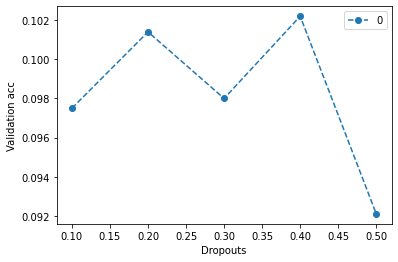

In [17]:
pd.DataFrame(dropout_acc.values(), index=dropout_acc.keys()).plot(
    xlabel="Dropouts", ylabel="Validation acc", style="--o")